In [3]:
import pandas as pd

df_sample = pd.read_csv("./sample_routes.csv")
df_sample

,tbl,Year,quarter,citymarketid_1,citymarketid_2,city1,city2,airportid_1,airportid_2,airport_1,...,carrier_lg,large_ms,fare_lg,carrier_low,lf_ms,fare_low,Geocoded_City1,Geocoded_City2,tbl1apk,route
0,Table1a,2021,3,30325,30466,"Denver, CO","Phoenix, AZ",11292,14107,DEN,...,WN,0.5098,133.45,AA,0.2062,121.14,NaN,NaN,202131129214107DENPHX,"Denver, CO-Phoenix, AZ"
1,Table1a,2021,3,30466,30559,"Phoenix, AZ","Seattle, WA",14107,14747,PHX,...,AS,0.4525,130.35,WN,0.2302,116.76,NaN,NaN,202131410714747PHXSEA,"Phoenix, AZ-Seattle, WA"
2,Table1a,2021,3,30721,32457,"Boston, MA (Metropolitan Area)","San Francisco, CA (Metropolitan Area)",10721,13796,BOS,...,WN,0.5494,319.14,WN,0.5494,319.14,NaN,NaN,202131072113796BOSOAK,"Boston, MA (Metropolitan Area)-San Francisco, ..."
3,Table1a,2021,3,30721,32457,"Boston, MA (Metropolitan Area)","San Francisco, CA (Metropolitan Area)",10721,14771,BOS,...,B6,0.4795,419.18,UA,0.3009,411.61,NaN,NaN,202131072114771BOSSFO,"Boston, MA (Metropolitan Area)-San Francisco, ..."
4,Table1a,2021,3,30721,32457,"Boston, MA (Metropolitan Area)","San Francisco, CA (Metropolitan Area)",10721,14831,BOS,...,B6,0.6287,317.16,DL,0.1461,288.81,NaN,NaN,202131072114831BOSSJC,"Boston, MA (Metropolitan Area)-San Francisco, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1868,Table1a,2024,1,30721,32457,"Boston, MA (Metropolitan Area)","San Francisco, CA (Metropolitan Area)",14307,14831,PVD,...,DL,0.5769,490.30,WN,0.3077,217.61,NaN,NaN,202411430714831PVDSJC,"Boston, MA (Metropolitan Area)-San Francisco, ..."
1869,Table1a,2024,1,32467,30559,"Miami, FL (Metropolitan Area)","Seattle, WA",11697,14747,FLL,...,AS,0.5326,286.91,AS,0.5326,286.91,NaN,NaN,202411169714747FLLSEA,"Miami, FL (Metropolitan Area)-Seattle, WA"
1870,Table1a,2024,1,32467,30559,"Miami, FL (Metropolitan Area)","Seattle, WA",13303,14747,MIA,...,AS,0.4662,332.52,AS,0.4662,332.52,NaN,NaN,202411330314747MIASEA,"Miami, FL (Metropolitan Area)-Seattle, WA"
1871,Table1a,2024,1,32467,34057,"Miami, FL (Metropolitan Area)","Portland, OR",11697,14057,FLL,...,AS,0.5744,252.02,AS,0.5744,252.02,NaN,NaN,202411169714057FLLPDX,"Miami, FL (Metropolitan Area)-Portland, OR"


In [4]:
# Check missingness
df_sample.isna().sum()

# Fill numeric columns with median
for col in ["fare", "fare_lg", "fare_low", "passengers"]:
    df_sample[col] = df_sample[col].fillna(df_sample[col].median())

# Drop rows with missing city info if any
df_sample = df_sample.dropna(subset=["city1", "city2"])


In [5]:
from scipy.stats.mstats import winsorize

for col in ["fare", "passengers"]:
    df_sample[col] = winsorize(df_sample[col], limits=[0.01, 0.01])  # cap 1% top/bottom


In [6]:
# Create quarter-based time index
df_sample["time_index"] = (df_sample["Year"] - df_sample["Year"].min()) * 4 + (df_sample["quarter"] - 1)

# Seasonality: quarter encoded as cyclical feature
import numpy as np

df_sample["quarter_sin"] = np.sin(2 * np.pi * df_sample["quarter"] / 4)
df_sample["quarter_cos"] = np.cos(2 * np.pi * df_sample["quarter"] / 4)


In [7]:
df_sample["avg_competitor_fare"] = (df_sample["fare_lg"] + df_sample["fare_low"]) / 2


In [8]:
df_sample["demand_index"] = df_sample["passengers"] / df_sample["nsmiles"]


In [9]:
df_sample["fare_diff"] = df_sample["fare"] - df_sample["avg_competitor_fare"]


In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_cols = ["fare", "passengers", "nsmiles", "demand_index", "fare_diff"]
df_sample[scaled_cols] = scaler.fit_transform(df_sample[scaled_cols])


In [11]:
df_sample["revenue"] = df_sample["fare"] * df_sample["passengers"]


In [12]:
df_sample.to_csv("processed_routes.csv", index=False)
print("processed_routes.csv ready for RL environment!")

processed_routes.csv ready for RL environment!


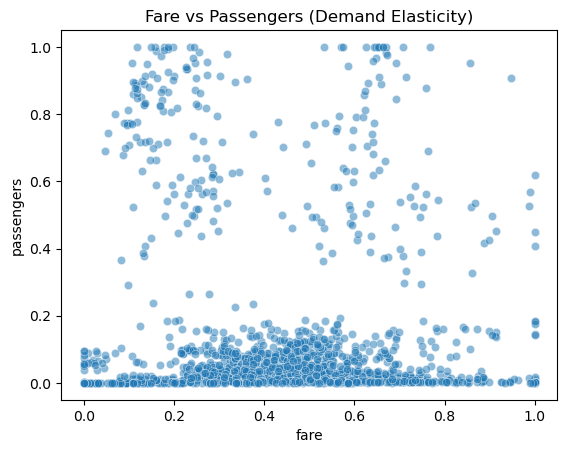

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x="fare", y="passengers", data=df_sample, alpha=0.5)
plt.title("Fare vs Passengers (Demand Elasticity)")
plt.show()
